# Importing necessary libraries for data manipulation, visualization, and machine learning


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import joblib

# The first section
stages of developing the deep learning model

Load the dataset

In [103]:
df = pd.read_csv('data_project.csv')
df.head()

,area,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,yr_built,yr_renovated,price
0,5650.0,3,1.00,1180,0,0,3,7,1955,0,2219.0
1,14484.0,3,2.25,2570,0,0,3,7,1951,1991,5380.0
2,10000.0,2,1.00,770,0,0,3,6,1933,0,1800.0
3,5000.0,4,3.00,1960,0,0,5,7,1965,0,6040.0
4,8080.0,3,2.00,1680,0,0,3,8,1987,0,5100.0


convert from square_feet to square_meter

In [104]:
df['area'] = df['sqft_living'] * 0.092903
df.head()

,area,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,yr_built,yr_renovated,price
0,109.62554,3,1.00,1180,0,0,3,7,1955,0,2219.0
1,238.76071,3,2.25,2570,0,0,3,7,1951,1991,5380.0
2,71.53531,2,1.00,770,0,0,3,6,1933,0,1800.0
3,182.08988,4,3.00,1960,0,0,5,7,1965,0,6040.0
4,156.07704,3,2.00,1680,0,0,3,8,1987,0,5100.0


In [105]:
df.shape

(21613, 11)

Filter out useless features

In [106]:
df = df[df['yr_renovated'] <= 0]
df = df[df['waterfront'] <= 0]
df = df.drop(columns=['yr_renovated','waterfront','yr_built','sqft_living'])
df.shape
df.isna().sum()

area         0
bedrooms     0
bathrooms    0
view         0
condition    0
grade        0
price        0
dtype: int64

Check for outliers

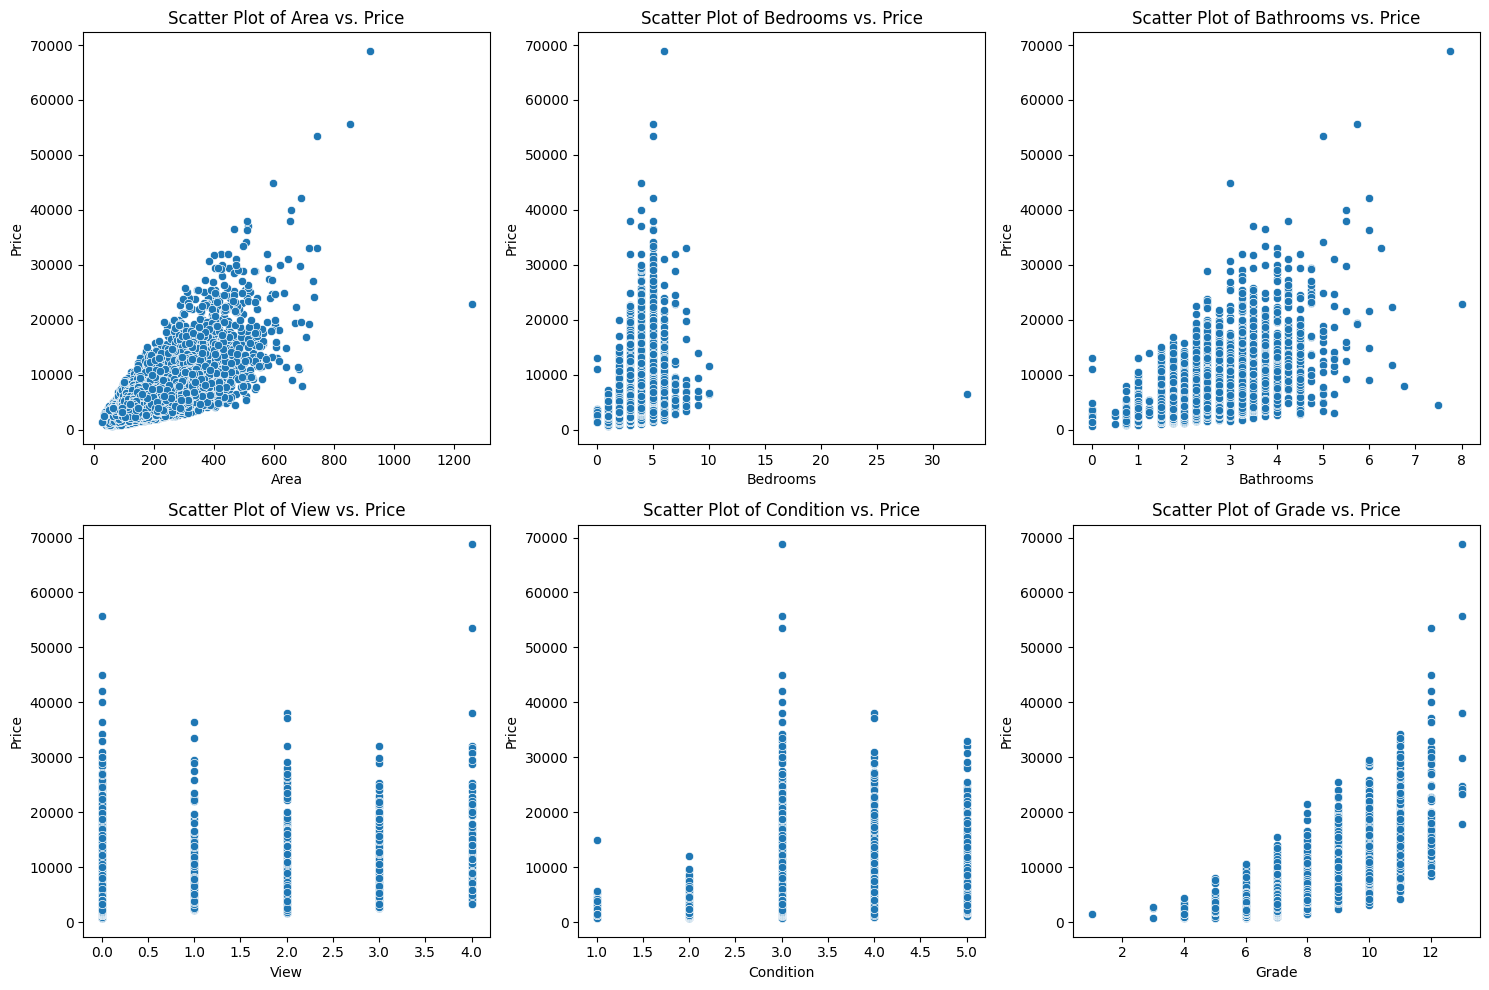

In [107]:

features = ['area', 'bedrooms', 'bathrooms', 'view', 'condition', 'grade']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='price', data=df)
    plt.title(f'Scatter Plot of {feature.capitalize()} vs. Price')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Price')

plt.tight_layout()

plt.show()


Removinge the outliers

In [108]:
import numpy as np

for column in df.columns:
    z_score_column = np.abs((df[column] - df[column].mean()) / df[column].std())
    
    df[f'z_score_{column}'] = z_score_column
    
    df = df[df[f'z_score_{column}'] <= 3.25]

df = df.drop(columns=[col for col in df.columns if 'z_score_' in col])

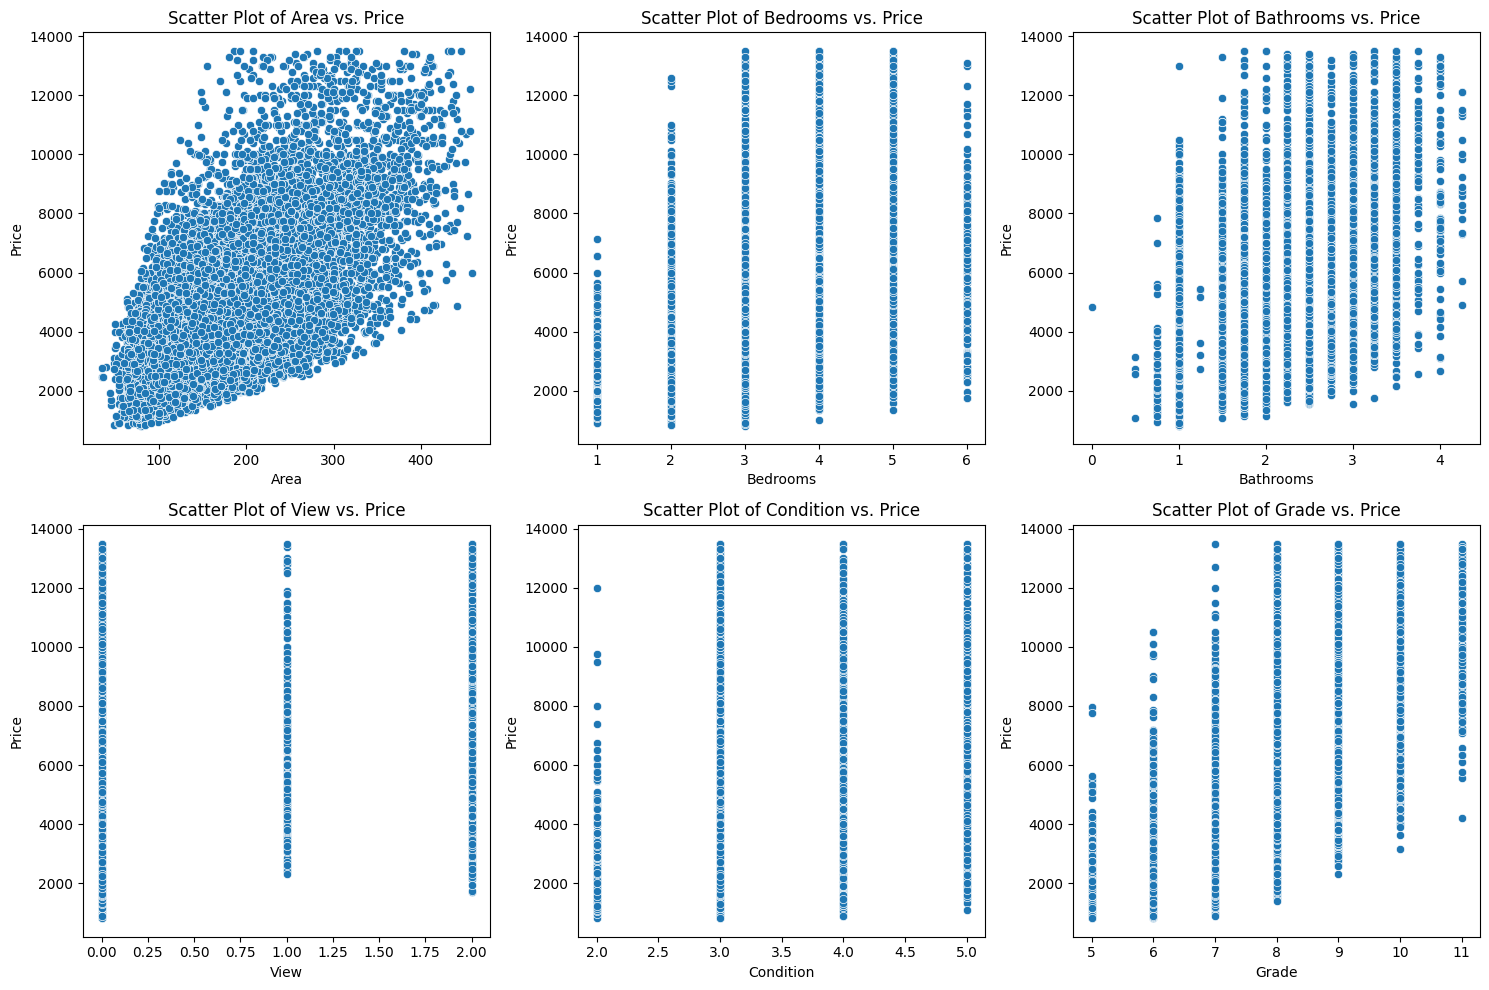

(19348, 7)

In [109]:
features = ['area', 'bedrooms', 'bathrooms', 'view', 'condition', 'grade']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='price', data=df)
    plt.title(f'Scatter Plot of {feature.capitalize()} vs. Price')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Price')

plt.tight_layout()

plt.show()
df.shape

In [110]:
df.describe()

,area,bedrooms,bathrooms,view,condition,grade,price
count,19348.000000,19348.000000,19348.000000,19348.000000,19348.000000,19348.000000,19348.000000
mean,182.994998,3.324065,2.045121,0.094945,3.417201,7.549721,4790.019414
std,71.006733,0.848841,0.690421,0.408633,0.645622,1.042320,2207.366979
min,34.374110,1.000000,0.000000,0.000000,2.000000,5.000000,820.000000
25%,130.064200,3.000000,1.500000,0.000000,3.000000,7.000000,3140.000000
50%,171.870550,3.000000,2.250000,0.000000,3.000000,7.000000,4350.000000
75%,225.754290,4.000000,2.500000,0.000000,4.000000,8.000000,5999.500000
max,458.011790,6.000000,4.250000,2.000000,5.000000,11.000000,13500.000000


In [111]:
X = df.drop(columns=['price']).values
y = df['price'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reshape the data for CNN

In [ ]:
X_scaled = np.expand_dims(X_scaled, axis=2)

Initialize KFold cross-validation and lists to store metrics for each fold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []
rmse_scores = []
r2_scores = []

Define the CNN model architecture (as a function)

In [ ]:
def create_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_scaled.shape[1], 1), kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Conv1D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

Perform cross-validation

In [ ]:
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_model()
    
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

Calculate average scores across all folds

In [ ]:
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

Display results

In [112]:
print("\nCNN Cross-Validation Performance:")
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R-squared: {mean_r2:.4f}")


121/121 [==============================] - 1s 4ms/step

CNN Cross-Validation Performance:
Mean MAE: 1165.0514
Mean RMSE: 1510.2903
Mean R-squared: 0.5314


plot Predict the prices using the trained model

605/605 [==============================] - 3s 4ms/step


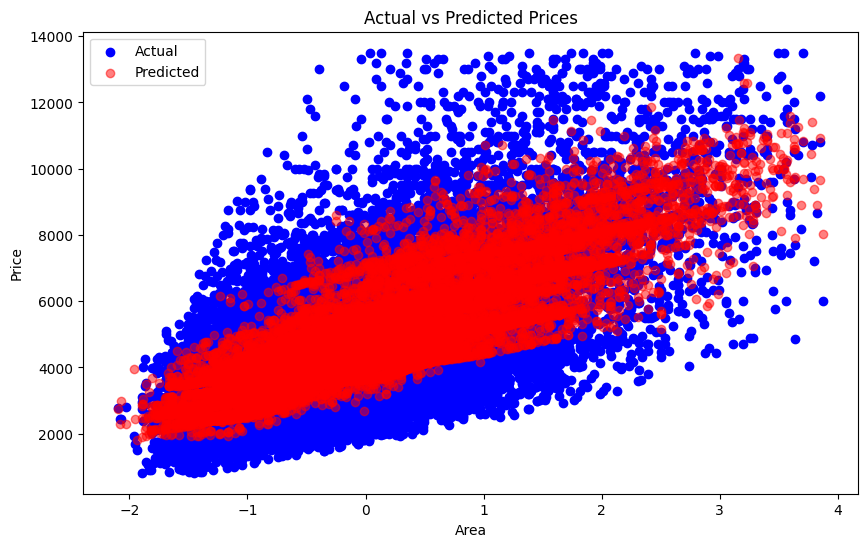

In [113]:
y_pred = model.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:,0], y, color='blue', label='Actual')

plt.scatter(X_scaled[:,0], y_pred, color='red', label='Predicted', alpha=0.5)

plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')

plt.legend()

plt.show()

In [114]:
df.describe()

,area,bedrooms,bathrooms,view,condition,grade,price
count,19348.000000,19348.000000,19348.000000,19348.000000,19348.000000,19348.000000,19348.000000
mean,182.994998,3.324065,2.045121,0.094945,3.417201,7.549721,4790.019414
std,71.006733,0.848841,0.690421,0.408633,0.645622,1.042320,2207.366979
min,34.374110,1.000000,0.000000,0.000000,2.000000,5.000000,820.000000
25%,130.064200,3.000000,1.500000,0.000000,3.000000,7.000000,3140.000000
50%,171.870550,3.000000,2.250000,0.000000,3.000000,7.000000,4350.000000
75%,225.754290,4.000000,2.500000,0.000000,4.000000,8.000000,5999.500000
max,458.011790,6.000000,4.250000,2.000000,5.000000,11.000000,13500.000000


For exsample

In [ ]:
base_home = {
    'bedrooms': 2,
    'bathrooms': 1,
    'view': 0,
    'condition': 5,
    'grade': 2,
    'area': 180
}

In [160]:
predicted_prices = []

home_df = pd.DataFrame([base_home])

home_scaled = scaler.transform(home_df)

home_scaled_reshaped = np.expand_dims(home_scaled, axis=2)

predicted_price = model.predict(home_scaled_reshaped)

offset = 1180
adjusted_price = predicted_price[0][0] * offset

predicted_prices.append((base_home['area'], adjusted_price))

for area, price in predicted_prices:
    print(f"Area: {area}, Predicted Price: ${price:,.0f}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 [==============================] - 0s 280ms/step
Area: 180, Predicted Price: $277,749,414


# The second section
Improve accuracy with more features

The location multipliers

In [116]:
location_multipliers = {
    'Al-Amara Al-Juwani': 18.5, 'Bab Touma': 19.5, 'Al-Qaymariyya': 21.2, 'Al-Hamidiyya': 24.1, 
    'Al-Hariqa': 24.11, 'Al-Marja': 26.1, 'Al-Amin': 11.8, 'Miathanet Al-Sham': 12.1, 
    'Shaghour Juwani': 11.76, 'Sarouja': 18.5, 'Al-Amara Al-Barani': 14.6, 'Al-Qasaa': 18.9, 
    'Al-Adawi': 18.7, 'Al-Qusour': 18.8, 'Baghdad Street': 22.4, 'Qanawat': 15.7, 
    'Al-Hijaz': 23.5, 'Al-Baramka': 24.0, 'Bab Al-Jabiyah': 17.6, 'Bab Srija': 17.92, 
    'Khalid Ibn Al-Walid Street': 16.3, 'Al-Sharbiyaat': 15.92, 'Al-Souyqa': 17.82, 
    'Al-Mujtahid': 17.85, 'Ghaws': 15.0, 'Al-Zahira Al-Jadida': 12.29, 'Al-Zahira Al-Qadima': 12.52, 
    'Al-Haqla': 13.21, 'Abu Habl': 12.4, 'Al-Qaa': 11.49, 'Bab Musalla': 15.33, 
    'Shaghour Barani': 10.89, 'Bab Sharqi': 22.24, 'Ibn Asakir': 14.12, 'Al-Nidal': 14.22, 
    'Al-Douyla': 5.8, 'Al-Zuhur': 4.12, 'Al-Tadamon': 3.85, 'Sayyida Aisha': 5.0, 
    'Al-Qadam Al-Asali': 3.9, 'Al-Qadam Sharqi': 3.4, 'Kafr Sousa Al-Balad': 21.4, 
    'Tanzim Kafr Sousa': 42.66, 'Al-Luwan': 5.2, 'Al-Mazzeh Sheikh Saad': 13.33, 
    'Mazzeh Jabal': 19.55, 'Mazzeh Eastern Villas': 24.52, 'Mazzeh Western Villas': 24.6, 
    'Mazzeh 86': 4.1, 'Moujamaa Dummar': 17.21, 'Eastern Dummar': 3.95, 'Western Dummar': 4.8, 
    'Barzeh Al-Balad': 3.35, 'Masakin Barzeh': 10.2, 'Pre-fabricated Barzeh': 12.3, 
    'Asha Al-Warour': 2.07, 'Al-Qaboun': 5.11, 'Ruken Al-Din': 22.64, 'Asad Al-Din': 21.2, 
    'Al-Faihaa': 22.55, 'Al-Salhiyeh': 24.2, 'Sheikh Muhyi Al-Din': 15.2, 
    'Al-Mazraa': 24.2, 'Al-Jisr Al-Abyad': 27.3, 'Arnos': 27.91, 'Al-Muhajireen': 21.51, 
    'Al-Rawda': 24.3, 'Abu Rummaneh': 36.4, 'Al-Malki': 34.9, 'Al-Afeef': 29.2
    }


In [117]:

def adjust_price_based_on_location_and_direction(predicted_price, location, direction):
    direction_multipliers = {
        "East and South": 1.10,
        "East and North": 1.05,
        "East and West": 1.00,
        "South and North": 0.95,
        "South and West": 0.95,
        "North and West": 0.85,
        "South and East": 1.10,
        "East": 1.05,
        "South": 1.05,
        "North": 0.90,
        "West": 0.95
    }

    # Get multipliers with default values
    location_multiplier = location_multipliers.get(location, 1.0)
    direction_multiplier = direction_multipliers.get(direction, 1.0)

    # Calculate final price
    final_price = predicted_price * location_multiplier * direction_multiplier
    return final_price



In [151]:
def combined_model_predict(features):
    cnn_features = np.array([[features['area'], features['bedrooms'], features['bathrooms'], 
                              features['view'], features['condition'], features['grade']]])
    
    cnn_features_scaled = scaler.transform(cnn_features)
    
    cnn_features_scaled_reshaped = np.expand_dims(cnn_features_scaled, axis=2)
    
    predicted_price = model.predict(cnn_features_scaled_reshaped)
    
    offset = 220000
    predicted_price_adjusted = predicted_price[0][0] * offset
    
    # Adjust price based on location and direction
    final_price = adjust_price_based_on_location_and_direction(predicted_price_adjusted, features['location'], features['direction'])
    
    return final_price


In [155]:
        input_data = {
            "area": 70,
            "bedrooms": 2,
            "bathrooms": 1,
            "view": 1,
            "condition": 3,
            "grade": 1,
            "location": "القاعة",
            "direction": "East and South"
        }

# Predict the price using the combined model
predicted_price = combined_model_predict(input_data)
print(f"The predicted price for the house is: {predicted_price}")

1/1 [==============================] - 0s 37ms/step
The predicted price for the house is: 675970872.0703125


# draft

In [ ]:
# Area: 10, Predicted Price: $7,952
# Area: 15, Predicted Price: $12,510
# Area: 20, Predicted Price: $17,017
# Area: 25, Predicted Price: $22,155
# Area: 30, Predicted Price: $29,010
# Area: 35, Predicted Price: $36,052
# Area: 40, Predicted Price: $43,141
# Area: 45, Predicted Price: $50,226
# Area: 50, Predicted Price: $56,194
# Area: 55, Predicted Price: $61,645
# Area: 60, Predicted Price: $67,191
# Area: 65, Predicted Price: $72,567
# Area: 70, Predicted Price: $77,942
# Area: 75, Predicted Price: $83,626
# Area: 80, Predicted Price: $89,400
# Area: 85, Predicted Price: $95,227
# Area: 90, Predicted Price: $101,096
# Area: 95, Predicted Price: $107,106
# Area: 100, Predicted Price: $113,401
# Area: 105, Predicted Price: $119,739
# Area: 110, Predicted Price: $126,078
# Area: 115, Predicted Price: $132,489
# Area: 120, Predicted Price: $139,049
# Area: 125, Predicted Price: $145,609
# Area: 130, Predicted Price: $152,169
# Area: 135, Predicted Price: $158,730
# Area: 140, Predicted Price: $165,290
# Area: 145, Predicted Price: $171,850
# Area: 150, Predicted Price: $178,410
# Area: 155, Predicted Price: $184,971
# Area: 160, Predicted Price: $191,531
# Area: 165, Predicted Price: $198,091
# Area: 170, Predicted Price: $204,651
# Area: 175, Predicted Price: $211,211
# Area: 180, Predicted Price: $217,772
# Area: 185, Predicted Price: $224,340
# Area: 190, Predicted Price: $230,910
# Area: 195, Predicted Price: $237,480
# Area: 200, Predicted Price: $244,050
# Area: 205, Predicted Price: $250,620
# Area: 210, Predicted Price: $257,190
# Area: 215, Predicted Price: $263,760
# Area: 220, Predicted Price: $270,330
# Area: 225, Predicted Price: $276,900
# Area: 230, Predicted Price: $283,470
# Area: 235, Predicted Price: $290,039
# Area: 240, Predicted Price: $296,609
# Area: 245, Predicted Price: $303,179
# Area: 250, Predicted Price: $309,749
# Area: 255, Predicted Price: $316,319
# Area: 260, Predicted Price: $322,889
# Area: 265, Predicted Price: $329,459
# Area: 270, Predicted Price: $336,029
# Area: 275, Predicted Price: $342,599
# Area: 280, Predicted Price: $349,169
# Area: 285, Predicted Price: $355,739
# Area: 290, Predicted Price: $362,309
# Area: 295, Predicted Price: $368,878
# Area: 300, Predicted Price: $375,447
# Area: 305, Predicted Price: $382,016
# Area: 310, Predicted Price: $388,584
# Area: 315, Predicted Price: $395,153
# Area: 320, Predicted Price: $401,722
# Area: 325, Predicted Price: $408,291
# Area: 330, Predicted Price: $414,860
# Area: 335, Predicted Price: $421,429
# Area: 340, Predicted Price: $427,998
# Area: 345, Predicted Price: $434,567
# Area: 350, Predicted Price: $441,136
# Area: 355, Predicted Price: $447,704
# Area: 360, Predicted Price: $454,273
# Area: 365, Predicted Price: $460,842
# Area: 370, Predicted Price: $467,411
# Area: 375, Predicted Price: $473,980
# Area: 380, Predicted Price: $480,549
# Area: 385, Predicted Price: $487,118
# Area: 390, Predicted Price: $493,687
# Area: 395, Predicted Price: $500,256
# Area: 400, Predicted Price: $506,825
# Area: 405, Predicted Price: $513,393
# Area: 410, Predicted Price: $519,962
# Area: 415, Predicted Price: $526,531
# Area: 420, Predicted Price: $533,100
# Area: 425, Predicted Price: $539,669
# Area: 430, Predicted Price: $546,238
# Area: 435, Predicted Price: $552,807
# Area: 440, Predicted Price: $559,376
# Area: 445, Predicted Price: $565,945
# Area: 450, Predicted Price: $572,514
# Area: 455, Predicted Price: $579,082
# Area: 460, Predicted Price: $585,651
# Area: 465, Predicted Price: $592,220
# Area: 470, Predicted Price: $598,789
# Area: 475, Predicted Price: $605,358
# Area: 480, Predicted Price: $611,927
# Area: 485, Predicted Price: $618,496
# Area: 490, Predicted Price: $625,065
# Area: 495, Predicted Price: $631,634
# Area: 500, Predicted Price: $638,203
# Area: 505, Predicted Price: $644,772
# Area: 510, Predicted Price: $651,340
# Area: 515, Predicted Price: $657,909
# Area: 520, Predicted Price: $664,478
# Area: 525, Predicted Price: $671,047
# Area: 530, Predicted Price: $677,616
# Area: 535, Predicted Price: $684,185
# Area: 540, Predicted Price: $690,754
# Area: 545, Predicted Price: $697,323
# Area: 550, Predicted Price: $703,892
# Area: 555, Predicted Price: $710,461
# Area: 560, Predicted Price: $717,029
# Area: 565, Predicted Price: $723,598
# Area: 570, Predicted Price: $730,167
# Area: 575, Predicted Price: $736,736
# Area: 580, Predicted Price: $743,305
# Area: 585, Predicted Price: $749,874
# Area: 590, Predicted Price: $756,443
# Area: 595, Predicted Price: $763,012
# Area: 600, Predicted Price: $769,581


In [ ]:
# location_values = {
#     'العمارة الجواني': 18.5,
#     'باب توما': 19.5,
#     'القيمرية': 21.2,
#     'الحميدية': 24.1,
#     'الحريقة': 24.11,
#     'المرجة': 26.1,
#     'الأمين': 11.8,
#     'مأذنة الشحم': 12.1,
#     'شاغور جواني': 11.76,
#     'ساروجة': 18.5,
#     'العمارة البرانية': 14.6,
#     'القصاع': 18.9,
#     'العدوي': 18.7,
#     'القصور': 18.8,
#     'شارع بغداد': 22.4,
#     'قنوات': 15.7,
#     'الحجاز': 23.5,
#     'البرامكة': 24.0,
#     'باب الجابية': 17.6,
#     'باب سريجة': 17.92,
#     'شارع خالد ابن الوليد': 16.3,
#     'الشربيشات': 15.92,
#     'السويقة': 17.82,
#     'المجتهد': 17.85,
#     'غواص': 15.0,
#     'الزاهرة الجديدة': 12.29,
#     'الزاهرة القديمة': 12.52,
#     'الحقلة': 13.21,
#     'ابو حبل': 12.4,
#     'القاعة': 11.49,
#     'باب مصلى': 15.33,
#     'شاغور براني': 10.89,
#     'باب شرقي': 22.24,
#     'ابن عساكر': 14.12,
#     'النضال': 14.22,
#     'الدويلة': 5.8,
#     'الزهور': 4.12,
#     'التضامن': 3.85,
#     'السيدة عائشة': 5.0,
#     'القدم العسالي': 3.9,
#     'القدم شرقي': 3.4,
#     'كفرسوسة البلد': 21.4,
#     'تنظيم كفرسوسة': 42.66,
#     'اللوان': 5.2,
#     'المزة الشيخ سعد': 13.33,
#     'مزة جبل': 19.55,
#     'المزة فيلات شرقية': 24.52,
#     'المزة فيلات غربية': 24.6,
#     'المزة 86': 4.1,
#     'مشروع دمر': 17.21,
#     'دمر الشرقية': 3.95,
#     'دمر الغربية': 4.8,
#     'برزة البلد': 3.35,
#     'مساكن برزة': 10.2,
#     'برزة مسبق الصنع': 12.3,
#     'عش الورور': 2.07,
#     'القابون': 5.11,
#     'ركن الدين': 22.64,
#     'أسد الدين': 21.2,
#     'الفيحاء': 22.55,
#     'الصالحية': 24.2,
#     'الشيخ محيي الدين': 15.2,
#     'المزرعة': 24.2,
#     'الجسر الابيض': 27.3,
#     'عرنوس': 27.91,
#     'المهاجرين': 21.51,
#     'الروضة': 24.3,
#     'ابو رمانة': 36.4,
#     'المالكي': 34.9,
#     'العفيف': 29.2
# }
